In [30]:
# %load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
# from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
# from torchsummary import summary


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Sun Mar  5 08:57:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    34W / 250W |    905MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                        transforms.Resize(32),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
                                       ])

transforms_cifar10 = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=transforms_mnist)

cifar10_data_train = datasets.CIFAR10('./data/cifar10/', train=True, download=True, transform=transforms_cifar10)
cifar10_data_test = datasets.CIFAR10('./data/cifar10/', train=False, download=True, transform=transforms_cifar10)

Files already downloaded and verified
Files already downloaded and verified


## Models

In [32]:
class LeNet(nn.Module):

    def __init__(self, data):
        super().__init__()
        if data == 'mnist':
            self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        elif data == 'cifar10':
            self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(400, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        out = self.sigmoid(x)
        return out

In [33]:
def train(model, epochs, train_dl, test_dl, optimizer, loss_fn, lr):

    train_losses = []
    accuracies = []
    start = time.time()

    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        model.train()
        for i, batch in enumerate(train_dl):
            image, label = batch
            if torch.cuda.is_available():
                image, label = image.cuda(), label.cuda()
            
            optimizer.zero_grad()
            y_pred = model(image)
            loss = loss_fn(y_pred, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= (i + 1)
        train_losses.append(train_loss)
        
        accuracy = test(model, test_dl)
        accuracies.append(accuracy)

    end = time.time()
    print('Training Done!')
    print(f'Time taken to train: {end - start}')

    return train_losses, accuracies

In [34]:
def test(model, test_dl):
    
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        for i, batch in enumerate(test_dl):
            image, label = batch

            if torch.cuda.is_available():
                image, label = image.cuda(), label.cuda()
                
            y_pred = model(image)
            value, preds = torch.max(y_pred, dim=1)
            correct += torch.sum(preds == label).item()
            total += image.size(0)
        accuracy = (correct / total) * 100
    return accuracy

In [35]:
model_mnist = LeNet('mnist').cuda()
epochs = 100
lr = 0.01
opt_mnist = torch.optim.SGD(model_mnist.parameters(), lr=lr)
loss_fn = nn. CrossEntropyLoss()

train_dl_mnist = DataLoader(mnist_data_train, batch_size=10, shuffle=True)
test_dl_mnist = DataLoader(mnist_data_test, batch_size=128, shuffle=True)

In [36]:
test(model_mnist, test_dl_mnist)

8.68

In [37]:
train_loss_mnist, accuracy_mnist = train(model_mnist, epochs, train_dl_mnist, test_dl_mnist, opt_mnist, loss_fn, lr)

100%|██████████| 100/100 [47:19<00:00, 28.39s/it]

Training Done!
Time taken to train: 2839.4975261688232


In [38]:
test(model_mnist, test_dl_mnist)

97.8

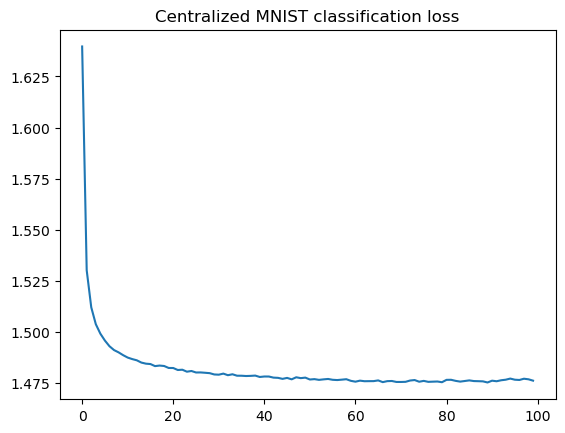

In [60]:
plt.plot(train_loss_mnist)
plt.title("Centralized MNIST classification loss")
plt.show()

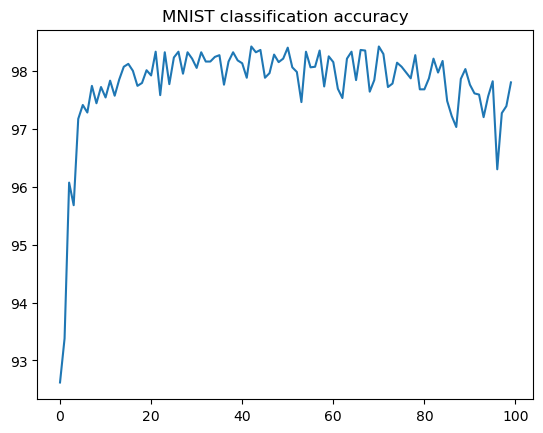

In [45]:
plt.plot(accuracy_mnist)
plt.title("MNIST classification accuracy")
plt.show()

In [64]:
print(f"Maximum accuracy for MNIST on LeNet: {round(max(accuracy_mnist),3)}")

Maximum accuracy for MNIST on LeNet: 98.42


In [46]:
model_cifar10 = LeNet('cifar10').cuda()
epochs = 100
lr = 0.01
opt_cifar10 = torch.optim.SGD(model_cifar10.parameters(), lr=lr)
loss_fn = nn. CrossEntropyLoss()

train_dl_cifar10 = DataLoader(cifar10_data_train, batch_size=10, shuffle=True)
test_dl_cifar10 = DataLoader(cifar10_data_test, batch_size=128, shuffle=True)

In [47]:
test(model_cifar10, test_dl_cifar10)

9.049999999999999

In [48]:
train_loss_cifar10 = train(model_cifar10, epochs, train_dl_cifar10, test_dl_cifar10, opt_cifar10, loss_fn, lr)

100%|██████████| 100/100 [38:06<00:00, 22.86s/it]

Training Done!
Time taken to train: 2286.0661804676056


In [53]:
train_loss_cifar10, accuracy_cifar10 = train_loss_cifar10

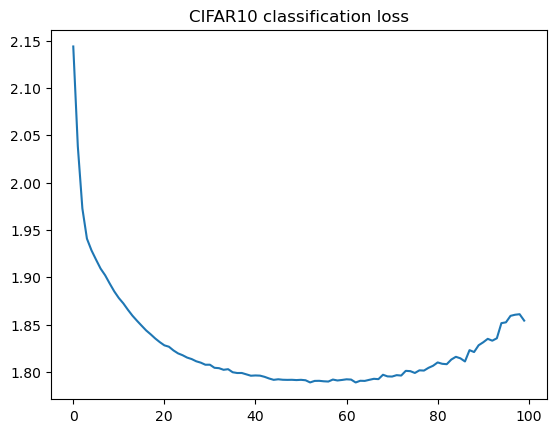

In [54]:
plt.plot(train_loss_cifar10)
plt.title("CIFAR10 classification loss")
plt.show()

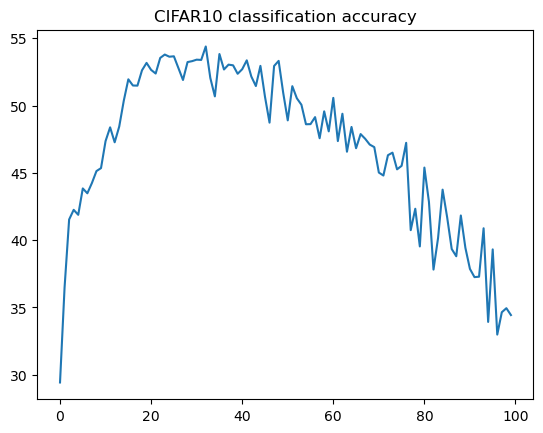

In [55]:
plt.plot(accuracy_cifar10)
plt.title("CIFAR10 classification accuracy")
plt.show()

In [62]:
print(f"Maximum accuracy for CIFAR10 on LeNet: {round(max(accuracy_cifar10),3)}")

Maximum accuracy for CIFAR10 on LeNet: 54.39


In [49]:
test(model_cifar10, test_dl_cifar10)

34.43